# Prosper Bank Loan Data Exploration
## by Albert Atsu Dellor


## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#EDA">Eploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## Introduction
<a id="intro"></a>

This project explores a dataset containing 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others to generate insights into the loan status of the bank's borrowers. 

It answers questions like :
What factors affect a loan‚Äôs outcome status?
What affects the borrower‚Äôs APR or interest rate?
Are there differences between loans depending on how large the original loan amount was?

## Data description

The dataset containing 113,937 loans with 81 features on each loan.
Due to the large set of features, this analysis won't analyse each but will focus on these:
- `ListingCategory`: This is a categorical variable that represents the loan's category or purpose, e.g. debt consolidation, home improvement, business, etc.
- `LoanStatus`: the ratio of the borrower's debt to their income
- `BorrowerAPR`: the annual percentage rate charged to the borrower
- `LoanOriginalAmount`: the original amount of the loan
- `BorrowerRate`: The interest rate that the borrower is paying on the loan.
- `LoanMonthsSinceOrigination`: The number of months that have passed since the loan was originated.
- `CreditScoreRangeLower`: The lower limit of the range in which the borrower's credit score falls.
- `CreditScoreRangeUpper`:The upper limit of the range in which the borrower's credit score falls.
- `StatedMonthlyIncome`: the amount of monthly income stated by the borrower
- `DebtToIncomeRatio`: the ratio of the borrower's debt to their income
- `EmploymentDuration`: the length of time the borrower has been employed in their current job.
- `Employment`: indicates if a loan is current, completed, or in default.
- `Occupation`: the borrower's occupation
- `IsBorrowerHomeowner`: indicates if the borrower owns a home
- `InquiriesLast6Months`: the number of credit inquiries made on the borrower in the last 6 months.
- `PublicRecordsLast12Months`: the number of public records in the borrower's credit history in the last 12 months.
- `DelinquenciesLast7Years`: Refers to the number of times the borrower has been delinquent on a payment in the last 7 years
- `CurrentCreditLines`: Represents the number of credit lines (e.g. credit cards, loans, etc.) currently open and being used by the borrower.
- `RevolvingCreditBalance`: Refers to the current outstanding balance on all revolving credit accounts, such as credit cards, that the borrower has
- `BankcardUtilization`: the ratio of the borrower's credit card balance to their credit limit
- `LoanCurrentDaysDelinquent`
- `TotalTrades`: the total number of trades in the borrower's credit history
- `CurrentDelinquencies`: the number of current delinquencies on the borrower's credit record

- `TotalInquiries`: The total number of credit inquiries made on the borrower's credit file in the past 6 months


### What features in the dataset do you think will help support the investigation into your feature(s) of interest?

Since the investigation is focused on the `loan outcome` the strongest features might be the ones that provide some kind of assurance to the lender about the borrowers ability to pay back and the justification for taking the loan. These are:

`BorrowerAPR`,`CreditScoreRangeLower`, `CreditScoreRangeUpper`,
`StatedMonthlyIncome`,`DebtToIncomeRatio`,`EmploymentDuration`,`Employment`,`Occupation`,`IsBorrowerHomeowner`,
`InquiriesLast6Months`, `PublicRecordsLast12Months`, `DelinquenciesLast7Years`,`ListingCategory`



# Data Wrangling
<a id="wrangling"></a>

In [158]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [159]:
# Loading the dataset
# Get the URL of the dataset
url = 'https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv'
# Create a Request and get url into loan_data variable
loan_data = requests.get(url)
# create file and write request content into file named loan_data.csv
with open(url.split('/')[-1], mode='wb') as file:
    file.write(loan_data.content)
    

In [160]:
loan_data = pd.read_csv('prosperLoanData.csv')

In [161]:
# check the number of entries and the features
print(loan_data.shape)

(113937, 81)


#### Remove columns not directly needed for analysis

In [162]:
drop =['ListingKey',
 'ListingNumber',
 'ListingCreationDate',
 'ClosedDate','LoanKey']
loan_data.drop(columns=drop,inplace=True)

Rename list category from numeric to corresponding  string value and rename column name for context

In [163]:
# replace list category from numeric to corresponding 
# string value and rename column name
replacement_dict={0:'Not Available',
                  1:'Debt Consolidation',
                  2:'Home Improvement',
                  3:'Business',
                  4:'Personal Loan',
                  5:'Student Use',
                  6:'Auto',
                  7:'Other',
                  8:'Baby&Adoption',
                  9:'Boat',
                  10:'Cosmetic Procedure',
                  11:'Engagement Ring',
                  12:'Green Loans',
                  13:'Household Expenses',
                  14:'Large Purchases',
                  15:'Medical/Dental',
                  16:'Motorcycle',
                  17:'RV',
                  18:'Taxes',
                  19:'Vacation',
                  20:'Wedding Loans'}
loan_data['ListingCategory (numeric)']=loan_data['ListingCategory (numeric)']\
                        .replace(replacement_dict)
loan_data.rename(columns={'ListingCategory (numeric)':'ListingCategory'},inplace=True)


summarise the various statges of Past Due (1-120days) into a single `Past Due` value for simplicity

In [164]:
import re
loanstatus =[]
for value in loan_data.LoanStatus:
    if re.search('Past', value):
        loanstatus.append(value.split('(')[0])
    else:
        loanstatus.append(value)
loan_data['loanstatus'] = loanstatus

In [165]:
loan_data['loanstatus'].unique()

array(['Completed', 'Current', 'Past Due ', 'Defaulted', 'Chargedoff',
       'Cancelled', 'FinalPaymentInProgress'], dtype=object)

In [166]:
# check for duplicates
loan_data.duplicated().sum()

0

In [167]:
# a detialed check on missing entries
missing_stats = loan_data.isnull().sum()
missing_value_count = missing_stats[missing_stats>0].count()
print('There are {} columns with one or more missing values. However there are no duplicated entries'\
      .format(missing_value_count))


There are 42 columns with one or more missing values. However there are no duplicated entries


In [168]:
loan_data.shape

(113937, 77)

# Exploratory Data analysis
<a id="EDA"></a>

## Univariate Exploration 

> - 1. What is the loan status of borrowers in prosper bank?

In [169]:
order_type = loan_data.loanstatus.value_counts().index

def countplot(df,col,order_type):
    base_col= sb.color_palette()[9]
    if order_type is not None:
        sb.countplot(data=df, x=col ,color=base_col,order=order_type);
    else:
        sb.countplot(data=df, x=col ,color=base_col);
    plt.xticks(rotation=75);
    

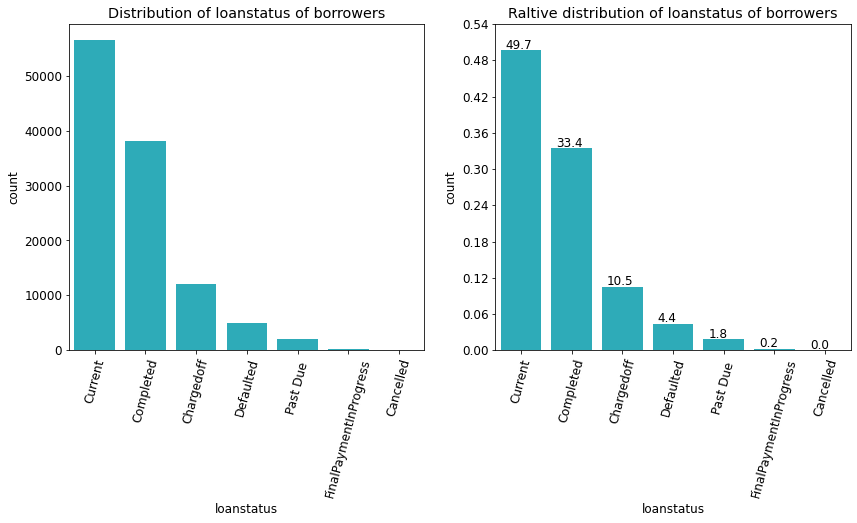

In [170]:
plt.figure(figsize=(14,6))
plt.rcParams['font.size'] = 12
# return all the non-null values in the LoanStatus column 
n_loantstatus = loan_data['loanstatus'].value_counts().sum()

# return the higest frequency in the LoanStatus column
loanstatus_count = loan_data.loanstatus.value_counts()
max_loanstatus_count = loanstatus_count[0]

# compute thelength of the longest bar in terms of the proportion
max_prop = max_loanstatus_count/n_loantstatus
max_prop

# create an array of evenly spaced proportioned values
tick_prop = np.arange(0,max_prop+0.07,0.06)
tick_names = ['{:0.2f}'.format(v) for v in tick_prop]
tick_names

plt.subplot(1,2,2)
countplot(loan_data,'loanstatus',order_type)
plt.xticks(rotation=75);
plt.yticks(n_loantstatus*tick_prop,tick_names);
plt.title('Raltive distribution of loanstatus of borrowers');
for i in range (loanstatus_count.shape[0]):
    # Remember, type_counts contains the frequency of unique values in the `type` column in decreasing order.
    count = loanstatus_count[i]
    # Convert count into a percentage, and then into string
    pct_string = '{:0.1f}'.format(100*count/n_loantstatus)
    # Print the string value on the bar. 
    plt.text(i-0.3,count+1000, pct_string, va='center')

plt.subplot(1,2,1)    
countplot(loan_data,'loanstatus',order_type)
plt.title('Distribution of loanstatus of borrowers');

 The bar graph of loan status reveal that the majority of Prosper bank's client are in good standing and have either completely paid off their loans or are actively in the process of paying off while a small proportion of their borrowers are being chargedoff or defaulting, past due, cancelled (not in good standing with bank).

To be specific, about a third of loans given out have been fully repaid (`complete`) with about half of all borrowers currently in the process of paying off loans(`current`).Only about one-tenth of loans have been `chargedoff`, leaving only about 4.4% `defaulted` and 1.8% of loans in various stages of being defaulted by 1 to 120 days `past due`.

Therefore, Prosper's bank is actually prospering. A deeper investigation to find the dollar value of these loan status will continue to assertain the average amount of loans being paid off, whether they are mostly small loans or big loans.

> - 2. For the borrowers in good standing (current) and those not in good standing (cancelled), what are their reasons for taking loans?

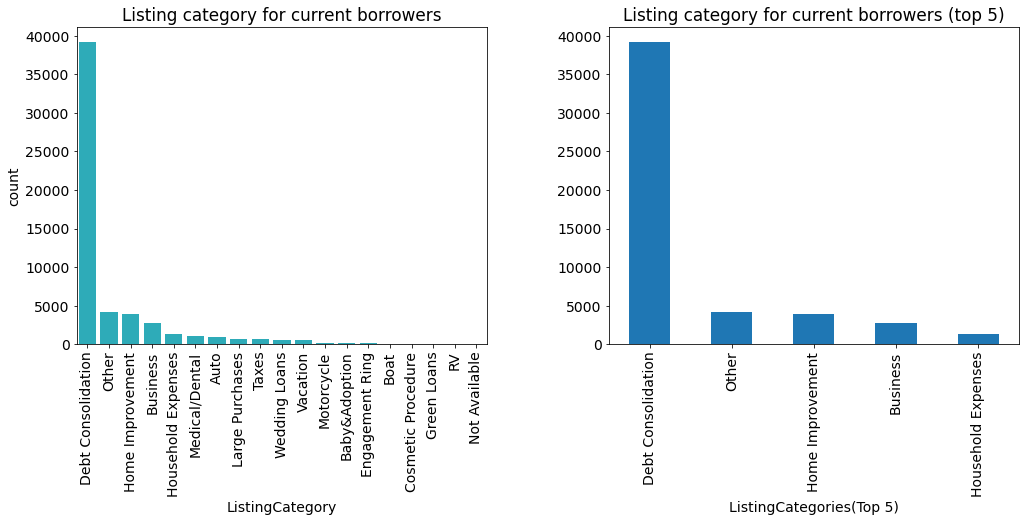

In [171]:
plt.figure(figsize=(16,9))
plt.rcParams['font.size'] = 14
current_stat = loan_data.query("loanstatus =='Current'")
order = current_stat.ListingCategory.value_counts().index
plt.subplot(1,2,1)
countplot(current_stat,'ListingCategory',order_type=order)
plt.xticks(rotation=90)
plt.title('Listing category for current borrowers')

plt.subplot(1,2,2)
order = current_stat.ListingCategory.value_counts()
color = sb.color_palette()[0]
order[:5].plot(kind='bar',color=color)
plt.xlabel('ListingCategories(Top 5)');
plt.tight_layout(pad=5)
plt.title('Listing category for current borrowers (top 5)');
plt.tight_layout(pad=5)


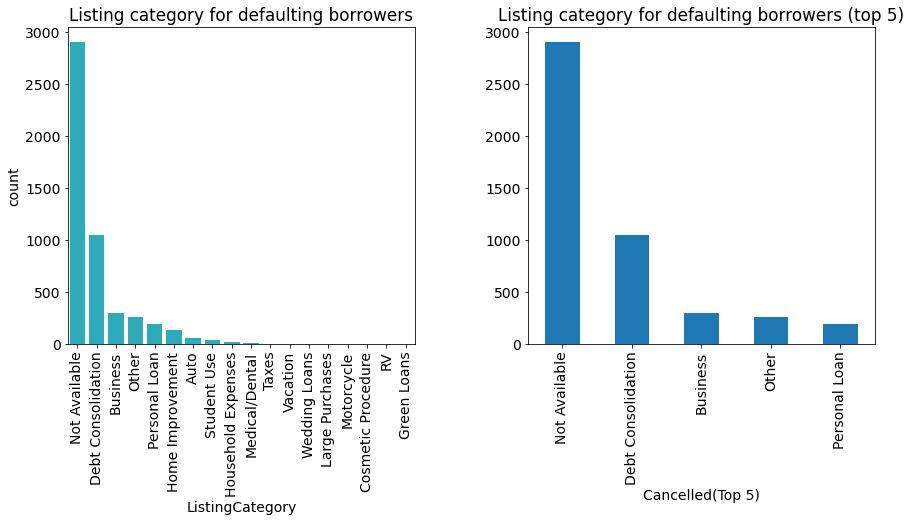

In [172]:

plt.figure(figsize=(14,9))
current_stat = loan_data.query("loanstatus =='Defaulted'")
order = current_stat.ListingCategory.value_counts().index
plt.subplot(1,2,1)
countplot(current_stat,'ListingCategory',order_type=order)
plt.xticks(rotation=90)
plt.title('Listing category for defaulting borrowers')

plt.subplot(1,2,2)
order = current_stat.ListingCategory.value_counts()
color = sb.color_palette()[0]
order[:5].plot(kind='bar',color=color)
plt.xlabel('Cancelled(Top 5)');
plt.title('Listing category for defaulting borrowers (top 5)');
plt.tight_layout(pad=5)


  For current borrowers, the most frequent reasons why they are taking loans are (in descending order) : 

- `Debt consolidation` > `undefined` > `home investment` > `business` > `household expensis` 

Whilst for defaulting borrowers, they are (in descending order) : 

- `Not available` > `debt consolation` > `business` > `other` > `personal loan`

The reasons common to both groups are:
`debt consolation` and `business`

whilst a reason found in only defaulting borrowers is `personal loan`

Therefore, borrowers who take personal loans are more likely to default. This may be because they quickly spend it without really thinking about repayment.

`NB`: Debt consolidation is the process of combining multiple debts into a single, lower interest loan to simplify and potentially reduce the overall cost of repaying debt. This is typically achieved by taking out a new loan to pay off existing debts, resulting in a single monthly payment to the new lender.


> - 3. What is the distribution of the BorrowerAPR, which is the annual interest rate that the borrower is paying? 
what is the most frequent APR and why? 

In [173]:
# order_type = loan_data.BorrowerAPR.value_counts().index

def histplot(data, focus, bins=None):
    if bins is not None:
        plt.hist(data[focus].dropna(),bins=bins)
        plt.tight_layout(pad=5)
    else:
        plt.hist(data,x=data[focus].dropna())
        plt.tight_layout(pad=5)


In [174]:
# the BorrowerAPR is multiplied by 100 to express it in  perentage
loan_data['BorrowerAPR%'] = loan_data['BorrowerAPR']*100.0

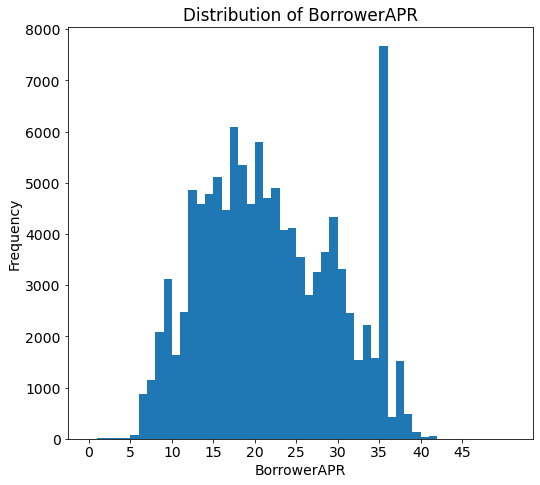

In [175]:
bins =np.arange(0,loan_data['BorrowerAPR%'].max()+0.5,1)
plt.figure(figsize=(9,8))
histplot(loan_data,'BorrowerAPR%',bins)
ticks = np.arange(0,50,5);
plt.xticks(ticks,ticks);
plt.xlabel('BorrowerAPR');
plt.ylabel('Frequency');
plt.title('Distribution of BorrowerAPR');

Small bin sizes reveal that there are interest rates peaks at 9%,19%, 29% and 35%. It is interesting to see that BorrowerAPR of 35% is the most frequent. These interest rate may represent standard interest rates on loans, with 35% APR being the most frequent. These APR may depend on certain criteria such as risk. In the next section I would investigate the relation ship between `loan status` and `borrowerAPR`. to see if the interest rates affect the status of the loans.

> - 4. Between the group of home owners and non-home owners, which group dominates in borrowing?
Does the bank have a preference among these groups?

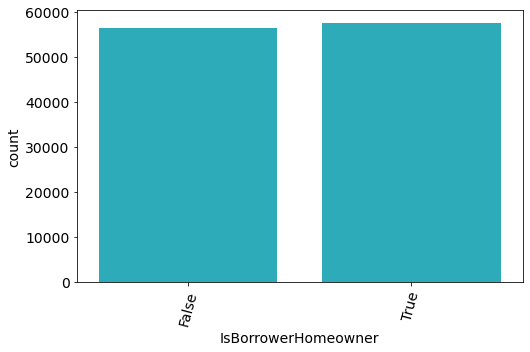

In [176]:
plt.figure(figsize=(8,5))
countplot(loan_data,'IsBorrowerHomeowner',order_type=None)


Judging from the chart, these groups borrow at almost the same frequency. Therefore Prosper bank doesn't discriminate between home owners and non-homeowners when it comes to lending.

> - 5. What do these borrowers do for a living?.
They must have some means of paying back the loan.

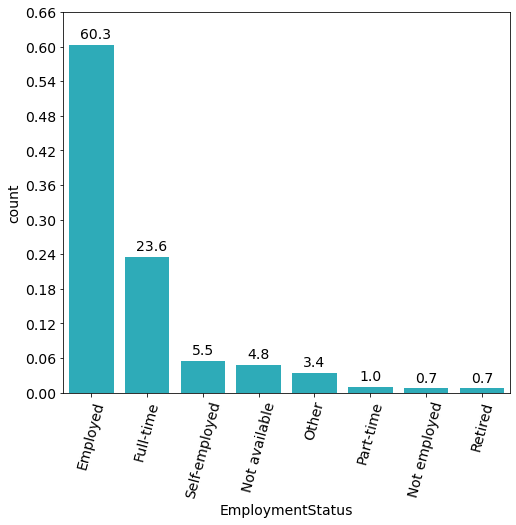

In [177]:
order_type = loan_data['EmploymentStatus'].value_counts().index

# return all the non-null values in the employment column 
n_EmploymentStatus = loan_data['EmploymentStatus'].value_counts().sum()

# return the higest frequency in the LoanStatus column
EmploymentStatus_count = loan_data.EmploymentStatus.value_counts()
max_EmploymentStatus_count = EmploymentStatus_count[0]

# compute thelength of the longest bar in terms of the proportion
max_prop = max_EmploymentStatus_count/n_EmploymentStatus
max_prop

# create an array of evenly spaced proportioned values
tick_prop = np.arange(0,max_prop+0.07,0.06)
tick_names = ['{:0.2f}'.format(v) for v in tick_prop]

plt.figure(figsize=(8,7))
countplot(loan_data,'EmploymentStatus',order_type=order_type)
plt.xticks(rotation=75);
plt.yticks(n_EmploymentStatus*tick_prop,tick_names);

for i in range (EmploymentStatus_count.shape[0]):
    # Remember, type_counts contains the frequency of unique values in the `type` column in decreasing order.
    count = EmploymentStatus_count[i]
    # Convert count into a percentage, and then into string
    pct_string = '{:0.1f}'.format(100*count/n_EmploymentStatus)
    # Print the string value on the bar. 
    plt.text(i-0.2,count+2000, pct_string, va='center')

The bar graph indeed show that majority of the borrowers have some form of employment. Specifically, 60.3 % of them having employment, with 21.6% being full time employment and 5.5 % being self-emplyed. This is important as the borrower would need to have some means of paying back the loan.


> - 6.What does the amounts of money being loaned out to borrowers look like?

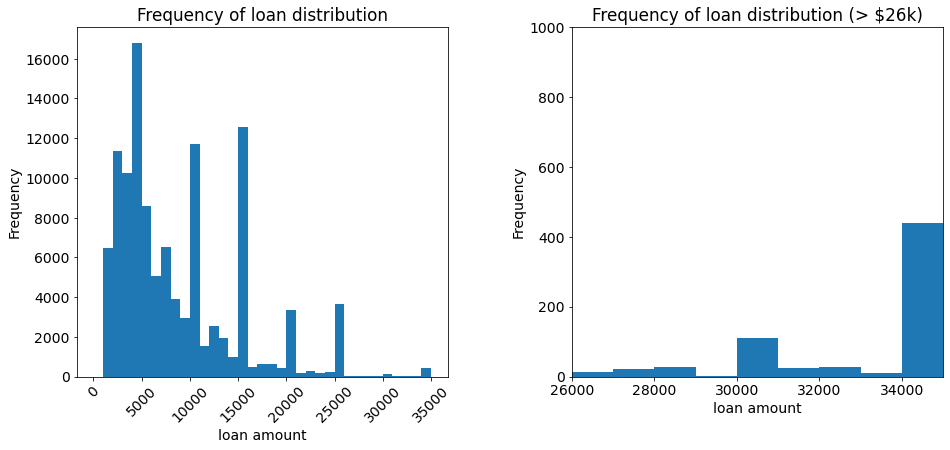

In [178]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
bins = np.arange(0,loan_data['LoanOriginalAmount'].max()+1000,1000)
histplot(loan_data,'LoanOriginalAmount',bins=bins)
plt.xlabel('loan amount')
plt.ylabel('Frequency')
plt.xticks(rotation=45);
plt.tight_layout(pad=5.0);
plt.title('Frequency of loan distribution');

plt.subplot(1,2,2)
bins = np.arange(0,loan_data['LoanOriginalAmount'].max()+1000,1000)
histplot(loan_data,'LoanOriginalAmount',bins=bins)
plt.xlim([26000,35000]);
plt.ylim([0,1000]);
plt.xlabel('loan amount');
plt.ylabel('Frequency');
plt.title('Frequency of loan distribution (> $26k)');

Taking a look at loans givent out, the distribution is left skwed however there are large peaks in frequency at amounts such as `$4K`, `$10K` ,`$15K` , `$20K` , `$25K`. These may represent standard limits for loans to individual depending on their profile or risk.

Zooming in into lower right section reveal that only few loans above 26K were offered. It could be only few borrowers qualify for such loans.

>- 7. what does the monthly income and debt-to-income of borrowers look like?

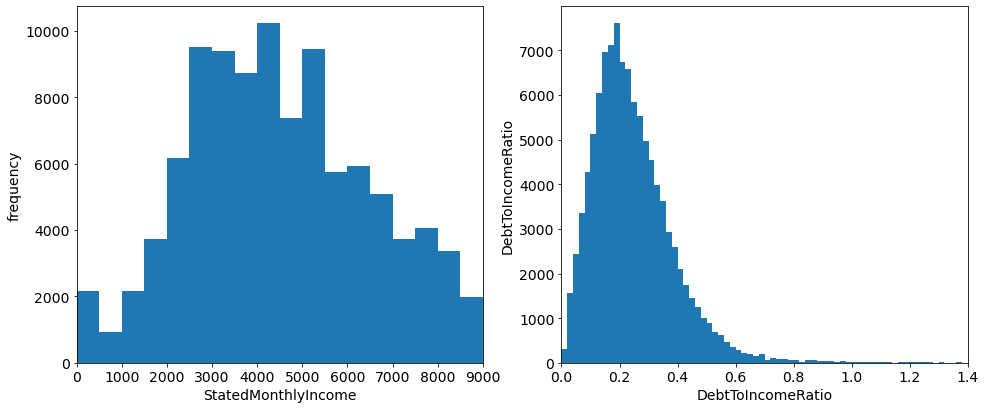

In [179]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
bins = np.arange(0,loan_data['StatedMonthlyIncome'].max()+200,500)
histplot(loan_data,'StatedMonthlyIncome', bins=bins)
plt.xlim([0,9e3]);
plt.tight_layout(pad=1.30)
plt.xlabel('StatedMonthlyIncome');
plt.ylabel('frequency');

plt.subplot(1,2,2)
bins = np.arange(0,loan_data['DebtToIncomeRatio'].max()+0.01,0.02)
histplot(loan_data,'DebtToIncomeRatio',bins=bins);
plt.xlim([0,1.4]);
plt.xlabel('DebtToIncomeRatio');
plt.ylabel('DebtToIncomeRatio');
plt.tight_layout(pad=1.30)

Exploring the monthly income (left) of the borrowers reveal a unimodal histogram. With most borrowers making a salary ranging from `$2500` to `$5500`. 

The histogram reveals  (right) that the distribution is left skewed. with a mode of 0.2 debt to income ratio. this is reasonable as a high debt to income ratio can be an indication of risk and can affect borrowers loan acquisition

> - 8. what is the employment status duration of borrowers? 

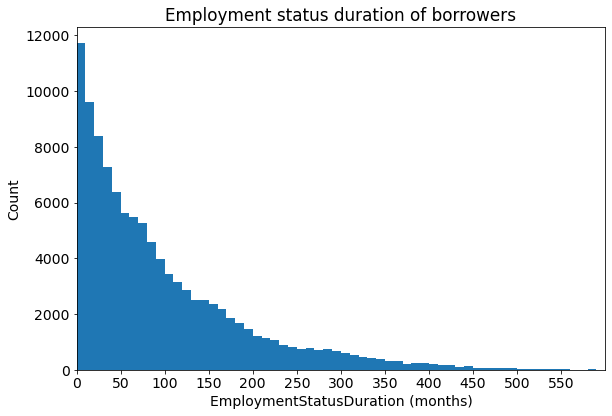

In [180]:
plt.figure(figsize=(10,7))
bins = np.arange(0,loan_data['EmploymentStatusDuration'].max()+5,10)
histplot(loan_data,'EmploymentStatusDuration',bins=bins)
plt.xlabel('EmploymentStatusDuration (months)');
ticks= np.arange(0,600,50)
plt.xticks(ticks,ticks);
plt.ylabel('Count')
plt.title('Employment status duration of borrowers')
plt.xlim([0,600]);


Exploring the employment status duration reveal a right skewed graph with the mode of between 1 to 10 months. It is eviedent that borrowers with lesser employment status duration make a majority of borrowers while more experienced workers with many months of emplyment duration make up the least category of borrowers. They may have gained financial independence after years of working compared to former.

> - 9.0 How many credit enquiries have borrowers had in the last 6 months?

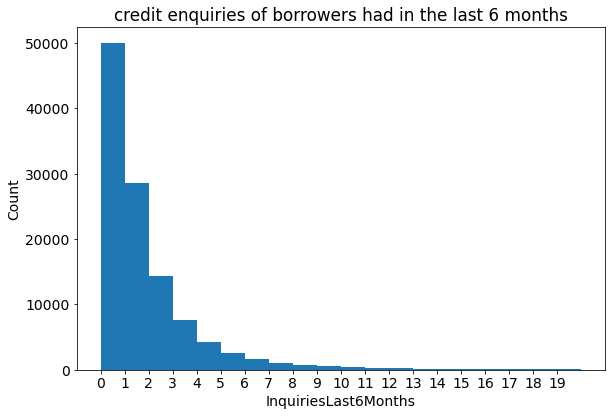

In [181]:
plt.figure(figsize=(10,7))
bins = np.arange(0,20+1,1)
ticks = np.arange(0,20,1)
histplot(loan_data,'InquiriesLast6Months',bins=bins)
plt.xticks(ticks,ticks);
plt.xlabel('InquiriesLast6Months');
plt.ylabel('Count')
plt.title('credit enquiries of borrowers had in the last 6 months');

This reveals a left skewed graph with the modal value of 1. The majority of borrowers have had their credit reports check only once within the past 6 month.

Inquiries Last 6 Months refers to the number of times a borrower's credit report has been checked or "pulled" by potential lenders or creditors in the past 6 months. Each time a credit report is pulled, it is recorded as an inquiry. Having too many inquiries in a short period of time can have a negative impact on a borrower's credit score as it suggests to lenders that the borrower is seeking.

> - 10. How many delinquencies  have the borrowers had in the past 7 years?

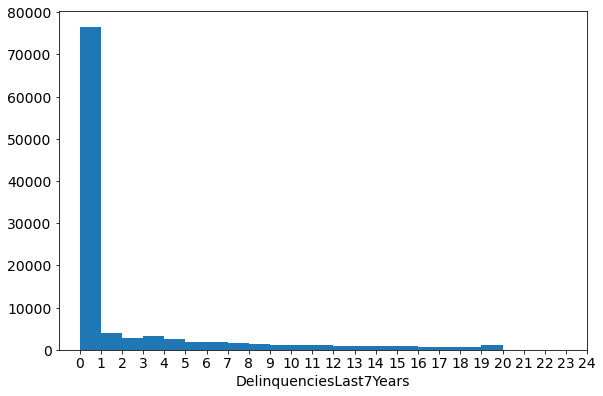

In [182]:
# bins = np.arange(0,60+1,5)
plt.figure(figsize=(10,7))

histplot(loan_data,'DelinquenciesLast7Years',bins=bins)
ticks = np.arange(0,25,1)
plt.xticks(ticks,ticks);
plt.xlabel('DelinquenciesLast7Years');

This histograph shows that the large proportion of borrowers have missed or is currently late on payment only once within the past 7 years.

Current Delinquencies refer to the number of payments that a borrower has missed or is currently late on. It is an indicator of the borrower's current level of credit risk and can have a significant impact on their credit score. Lenders consider a borrower's current delinquencies when evaluating loan applications and determining the interest rate and other terms of the loan. A high number of current delinquencies can indicate a higher risk of default and result in a lower credit score, making it more difficult for the borrower to obtain credit in the future. 

### What are the distribution(s) of the variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
The LoanStatus feature values `Past Due (1-15 days),``Past Due (16-30 days)`,`Past Due (31-60 days)`,`Past Due (61-90 days)`, `Past Due (91-120 days)`,`Past Due (>120 days)` were all repalced with Past Due for simplicity


### Of the features investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
The distribution of the BorrowerAPR almost seems to be normally distibuted. but with smaller binsize there is tall peak at 35% APR. This looks a bit unusual as an APR of 35% is quite high. The APR was multiplied by 100 to express it in percentage.

The distribution of the original loan amount show that there are large peaks in frequency at amounts such as  4K, 10K, 15ùêæ, 20K, 25K. These may represent standard limits for loans to individual depending on their profile or risk.

Additionally, the CreditScoreRangeUpper and CreditScoreRangeLower features when plotted look the same.

- Is there any connection between home ownership and loan status? 

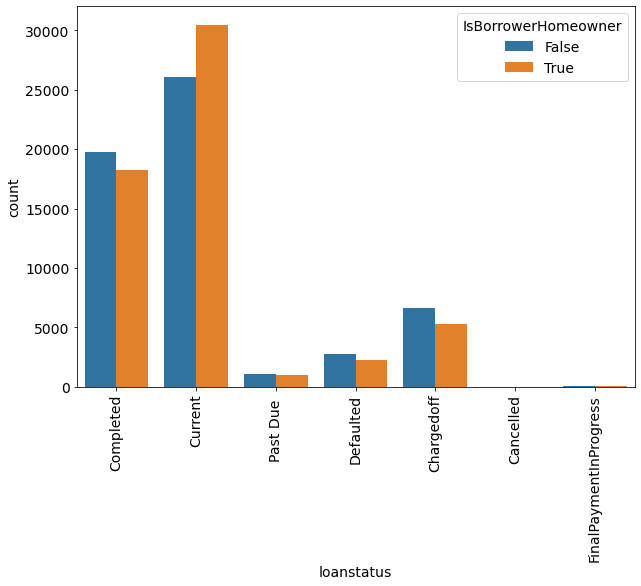

In [183]:
plt.figure(figsize=(10,7))
sb.countplot(data = loan_data, x = 'loanstatus', hue = 'IsBorrowerHomeowner')
plt.xticks(rotation=90);

I used the clustered bar chart to see whether there is a connection with owning a home and the status of borrowers. Interestingly there are more borrowers who have had their loans charged off or defaulted who are not home owners than those who are home owners.  And there are more borrowers who are currenlty in the process of paying back their loans who are home owners than those who are not. This could due to borrowers using their homes for collatoral and not wanting to lose their home, thus giving some incentive to rapay loans on schedule.

>Do borrowers in good standing with the bank have a higher monthly stated income than those in bad standing with the bank?

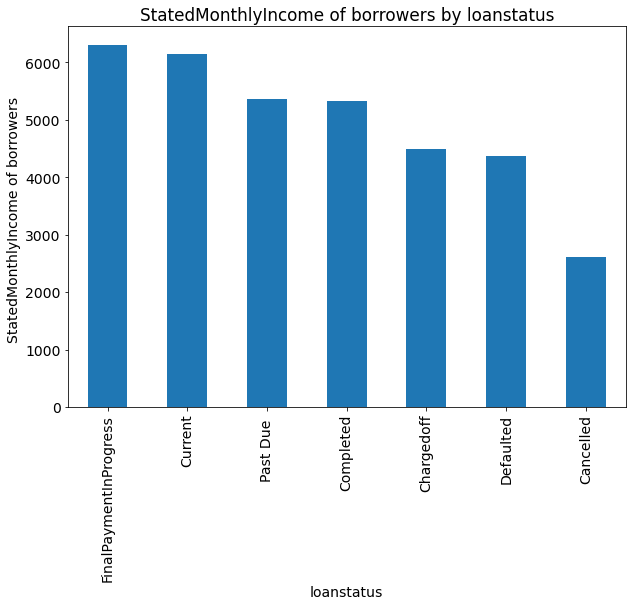

In [184]:
plt.figure(figsize=(10,7))
mean_loan_lower_status = loan_data.groupby('loanstatus')['StatedMonthlyIncome'].mean()
mean_loan_lower_status = mean_loan_lower_status.sort_values(ascending=False);
mean_loan_lower_status.plot(kind='bar',color = color);
plt.ylabel('StatedMonthlyIncome of borrowers ');
plt.title('StatedMonthlyIncome of borrowers by loanstatus');

borrowers in good standing with the bank have a higher monhtly stated income than those in bad standing with the bank

> Do borrowers in good standing with the bank have a higher credit score than those in bad standing with the bank?

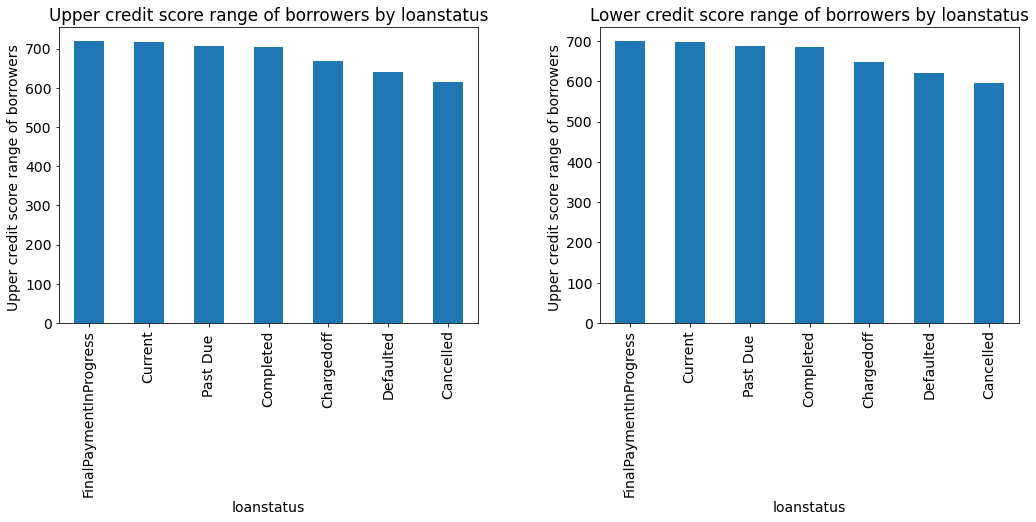

In [185]:
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
mean_upper_loan_status = loan_data.groupby('loanstatus')['CreditScoreRangeUpper'].mean()
mean_upper_loan_status = mean_upper_loan_status.sort_values(ascending=False);
mean_upper_loan_status.plot(kind='bar',color = color);
plt.ylabel('Upper credit score range of borrowers ');
plt.title('Upper credit score range of borrowers by loanstatus');
plt.tight_layout(pad=5)

plt.subplot(1,2,2)
mean_loan_lower_status = loan_data.groupby('loanstatus')['CreditScoreRangeLower'].mean()
mean_loan_lower_status = mean_loan_lower_status.sort_values(ascending=False);
mean_loan_lower_status.plot(kind='bar',color = color);
plt.ylabel('Upper credit score range of borrowers ');
plt.title('Lower credit score range of borrowers by loanstatus');
plt.tight_layout(pad=5)

It is surprising to see the stark similarity between both the upper and lower range of the credit scores. in the next section I would investigate Credit score and borrowersAPR. with borrowers loan status of finalpaymentprogress, current, past due and completed, in descending order have the highest credit score.

Whilst those have been charged off, defaulted, or had their loans cancelled have the lower credit scores
Thus, borrowers with good standing have higher credit scores, with the exception of those with loans past due. 

Thus, borrowers in good standing with the bank have a higher credit score than those in bad standing with the bank


>what is the mean amount borrowed by each borrower group?
Are the bank's biggest borrowers paying up?

In [186]:
loan_amt = loan_data.groupby('loanstatus')['LoanOriginalAmount'].mean()
loan_amt= loan_amt.sort_values(ascending=False).reset_index()
loan_amt.set_index('loanstatus')

LoanOriginalAmount
loanstatus                                
Current                       10360.835018
FinalPaymentInProgress         8346.121951
Past Due                       8258.437349
Defaulted                      6486.798525
Chargedoff                     6398.916694
Completed                      6189.093239
Cancelled                      1700.000000

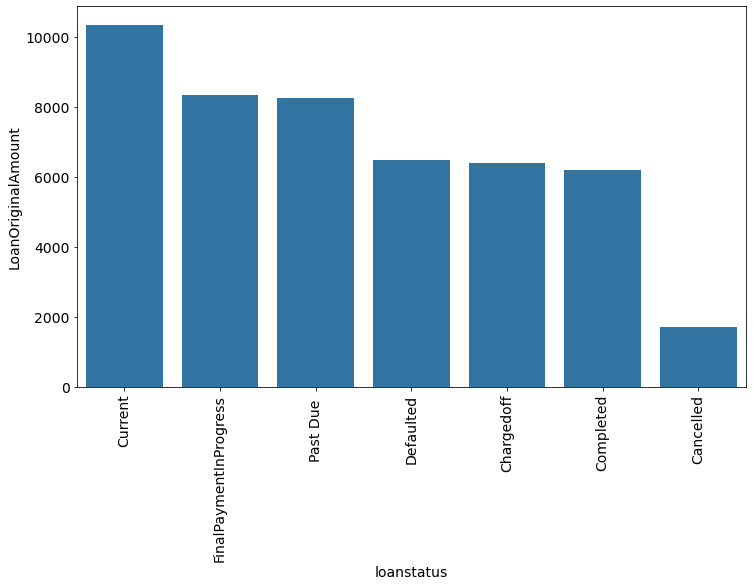

In [187]:
plt.figure(figsize=(12,7))
plt.tight_layout(pad=5)
base_color = sb.color_palette()[0]
sb.barplot(data=loan_amt,x='loanstatus',y='LoanOriginalAmount',\
           color=base_color)
plt.xticks(rotation=90);

#### Looking at the loan originally amount borrowed by borrowers, borrowers who borrowed the most  are those consistently rapaying (`curent`) and those making their last payment(` finalpaymentprogress` at `$10360` and `$8346` respectively.

Borrowers who have fully paid off their loans (`completed`) borrowed an average of `$6189.` 

Borrowers who had their loans cancelled borrowed an average of `$1700` which the lowest of all amount borrowed. It can be suggested that their loans were cancelled and forgiven because the amount borrowed was small and it might cost more to retreive those loans from borrowers.


>What is the annual interest rates of these borrower groups? Does their credit score play a role in these rates? Does the rates affect their rapayment?

In [188]:
# define function for seaborn's regplot and heatplot
def regplot(x,y):
    sb.regplot(data = loan_data, y= y, x = x);
    plt.ylabel(y)
    plt.xlabel(x)
               
def heatmap(list):
    sb.heatmap(loan_data[list].corr(),annot=True);

In [189]:
loan_score = loan_data.groupby('loanstatus')['CreditScoreRangeLower']\
        .mean()

loan_score_sort = loan_score.sort_values(ascending=False).index

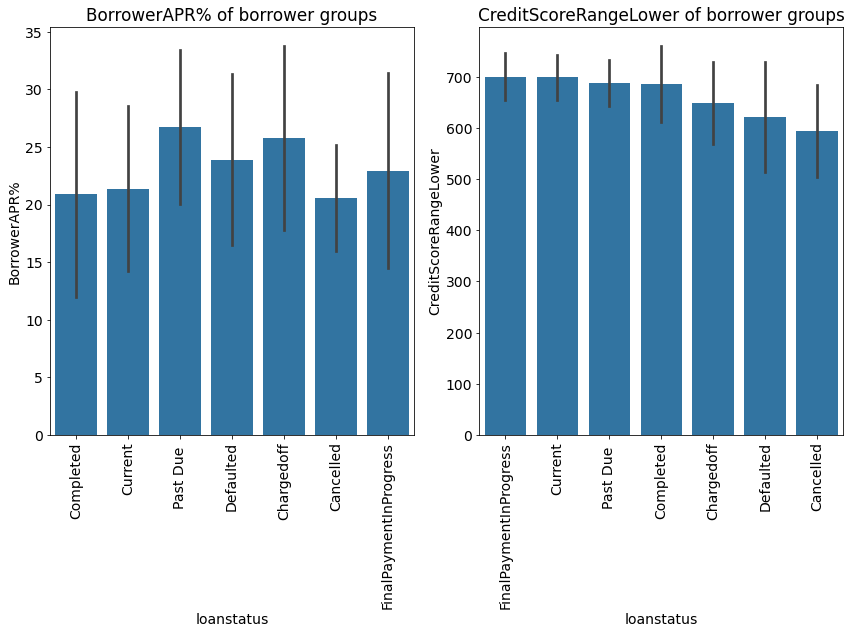

In [190]:

plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
sb.barplot(data=loan_data, x='loanstatus', y='BorrowerAPR%',\
           color=base_color, ci='sd')
plt.xticks(rotation=90);
plt.title('BorrowerAPR% of borrower groups')
plt.tight_layout(pad=1)

plt.subplot(1,2,2)
sb.barplot(data=loan_data, x='loanstatus',y='CreditScoreRangeLower'\
           , color=base_color, ci='sd',order=loan_score_sort)
plt.xticks(rotation=90);
plt.title('CreditScoreRangeLower of borrower groups')
plt.tight_layout(pad=1)



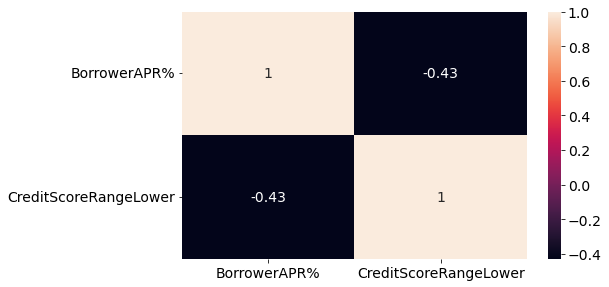

In [191]:
plt.figure(figsize=(17,10))
lists = ['BorrowerAPR%','CreditScoreRangeLower']
plt.subplot(2,2,3)
heatmap(lists)


With investigation, it looks like, with the exception of defaulted borrowers, the borrowers with the lowest `BorrowerAPR%` are the ones currenlty paying their loan on schedule, completed their loan payment, and those making their final payment. 

Borrowers who have past Due dates on their loans, defaluted, or have been charged off  are the ones with higher `borrowersAPR%` . 

Interestingly,the borrowers who have had their loan cancelled have the lowest `BorrowerAPR%` and yet they couldn't pay their loaons. This is not surprising because as seen from previous plot, they have the lowest reported income and were lended the lowest amount amongst the categories.

Additionally, for the barchat at the upper right, (loanstatus vrs credit score), with the exception of Past Due borrowers, borrowers with the highest credit score are thosecurrently paying their loans, those who completed payment and those making their final payment progress. Those who defaulted or had their loans cencelled have lowest average credit score. 
Borrowers with the smaller BorrowerAPR% are in good standing with the bank compared to  those who have defaulyed and past due date as they have higher borrowerAPR%.

This relationship is further exposed in the heatmap, as credit score an BorrowerAPR% are related with slight negetively correlation.  Thus an increase in one variable causes a slight decrease in the other (inversely related).  

>Also does credit score influence how much loan they get?

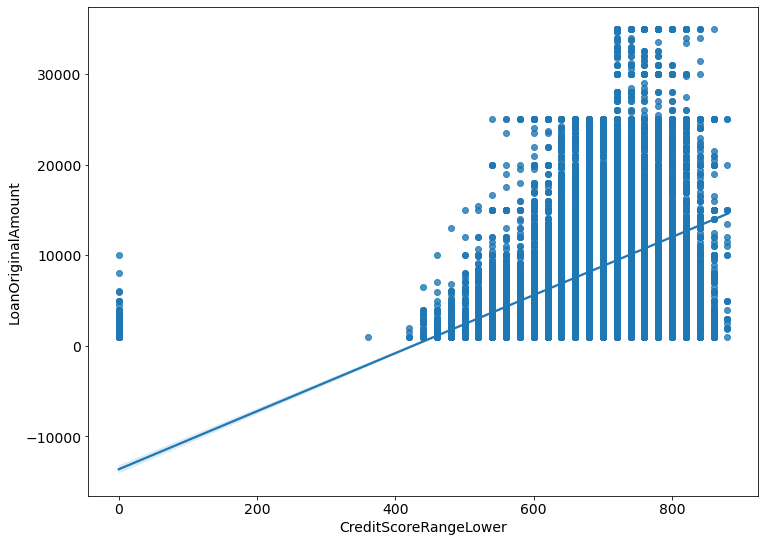

In [192]:
plt.figure(figsize=(12,9))
regplot('CreditScoreRangeLower','LoanOriginalAmount');


The increasing regresssionn line and scatter plot indicate that increasing credit score also increases loan original amount given to borrower. Therefore borrowers with the lowest credit score, also have the higher borrowerAPR%, earn the lower and struggle to repay their loans compared to those with higher credit score.  

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

1. Interestingly there are more borrowers who have had their loans charged off or defaulted who are not home owners than those who are home owners. And there are more borrowers who are currenlty in the process of paying back their loans who are home owners than those who are not. This could due to borrowers using their homes for collatoral and not wanting to lose their home, thus giving some incentive to rapay loans on schedule.
2. Investigating borrowers loan status against their amount borrowed indicate that borrowers who had their loans cancelled borrowed the least amount on average whilst those who are currently repaying their loans (including those making their final payment) borrowed the most. Their loans were forgiven probably because it was the least and might cost more to recover. 
3. Similarly, investigating borrowers loan status against their monthly income reveal that those making their final payment, currently paying their loans,and those who have completed their loan repayment earn highier on average compared to those who defaulted, were chargedoff or had thier loans cancelled. Borrowers who are late on their due date payments also earn higher.
4. High borrowerAPR might slow loan repayment, with the exception of defaulted borrowers, the borrowers with the lowest `BorrowerAPR%` are currenlty paying their loan on schedule, have completed their loan payment, or are making their final payment. While those with the highest `borrowersAPR%` are the ones who have past Due dates on their loans, defaluted, or have been charged off. Interestingly,the borrowers who have had their loan cancelled have the lowest `BorrowerAPR%` and yet they couldn't pay their loaons. This is not surprising because as seen from previous plot, they have the lowest reported income and were lended the lowest amount amongst the categories.
5. Additionally, a high credit score might indicate a higher a borrowers ability to repay loan as 
6. Borrowers with the smaller BorrowerAPR% are in good standing with the bank (currenlty paying their loan on schedule, have completed their loan payment, or are making their final payment) compared to those who have defaulyed and past due date as they have higher borrowerAPR%.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

1. Credit score and BorrowerAPR% are inversely related with slight negetively correlation.  Thus an increase in one variable causes a slight decrease in the other.
2. However, credit score is positively correlated with the amount of loans given, as increasing credit show increase in loan original amount given to borrower. Therefore borrowers with the lowest credit score, also have the higher borrowerAPR%, earn the lower and struggle to repay their loans compared to those with higher credit score.
3. Additionally,loan original amount (amount of loan given to borrower) increases slightly with increasing stated monthly income as there exist a sligt positive correlation of 0.2 between these two features

## Multivariate Exploration


>- 1. Of all the groups of borrowers, what are their mean monthly income and how much money are they borrowing ? 

In [193]:
loan_stat_income = loan_data.groupby(by='loanstatus')['StatedMonthlyIncome']\
        .mean().sort_values(ascending=False).reset_index()
# loan_stat_income

In [194]:
loan_stat_amount = loan_data.groupby(by='loanstatus')['LoanOriginalAmount']\
        .mean().sort_values(ascending=False).reset_index()
merged = loan_stat_amount.merge(loan_stat_income,left_on='loanstatus',right_on='loanstatus')
merged.sort_values(by='StatedMonthlyIncome',ascending=False)

loanstatus  LoanOriginalAmount  StatedMonthlyIncome
1  FinalPaymentInProgress         8346.121951          6311.738211
0                 Current        10360.835018          6153.262946
2               Past Due          8258.437349          5366.855830
5               Completed         6189.093239          5324.522029
4              Chargedoff         6398.916694          4485.996143
3               Defaulted         6486.798525          4366.768683
6               Cancelled         1700.000000          2608.933333

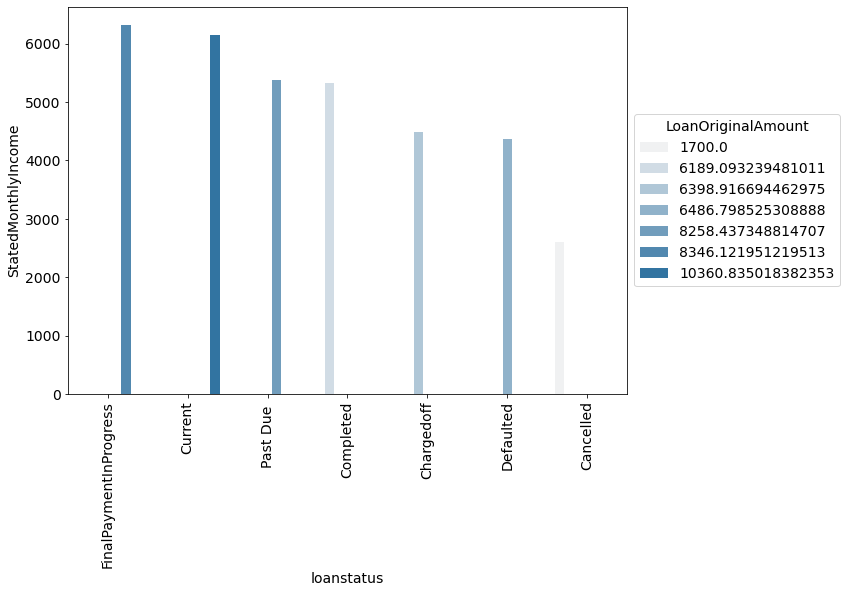

In [195]:
order = merged.loanstatus
plt.figure(figsize=(9,14))
plt.subplot(2,1,1)
base_color = sb.color_palette()[0]
sb.barplot(data=merged, x='loanstatus', y='StatedMonthlyIncome' \
           ,color = base_color,\
           hue='LoanOriginalAmount',
           order=merged.sort_values('StatedMonthlyIncome',ascending = False).loanstatus);
plt.xticks(rotation=90);
plt.tight_layout(pad=1)
plt.legend(loc = 6,
           bbox_to_anchor = (1.0, 0.5),
           title='LoanOriginalAmount'); # legend to right of figure


Of all the groups of borrowers, those in good standing with the bank have the higher montly income than those who are not and ended up borrowing more that those who are not ingood standing. 
Borrowers in good standnig: curent, completed and  those making their last payment(finalpaymentprogress) earn `$6311.738` , `$5324.522` and `$6153.262` respectively.

However, borrowers who had their loans cancelled earned the least average income of `$2608.933`

Therefore there is a realtionship between the LoanOriginalAmount (amount borrowed), StatedMonthlyIncome and loan status.

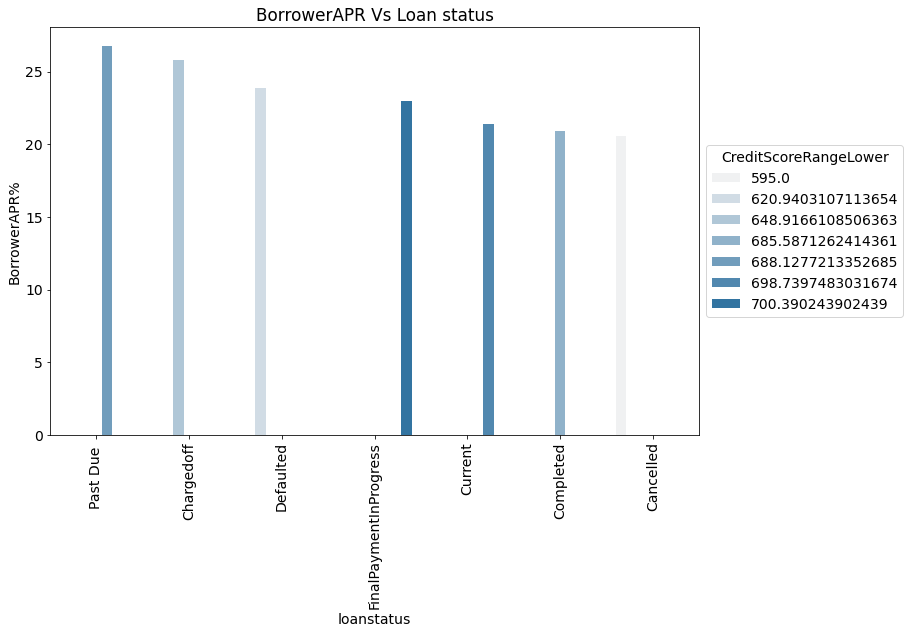

In [196]:
loan_credit = loan_data.groupby('loanstatus')['CreditScoreRangeLower']\
        .mean().sort_values(ascending=False).reset_index()


rate = loan_data.groupby('loanstatus')['BorrowerAPR%']\
        .mean().sort_values(ascending=False).reset_index()

merged = loan_credit.merge(rate,left_on='loanstatus',right_on='loanstatus')
merged.sort_values(by='BorrowerAPR%',ascending=False)

plt.figure(figsize=(10,9))
base_color = sb.color_palette()[0]
sb.barplot(data=merged, x='loanstatus', y='BorrowerAPR%' \
           ,color = base_color,\
           hue='CreditScoreRangeLower',
           order=merged.sort_values('BorrowerAPR%',ascending = False).loanstatus);
plt.title('BorrowerAPR Vs Loan status')
plt.xticks(rotation=90);
plt.tight_layout(pad=1)
plt.legend(loc = 6,
           bbox_to_anchor = (1.0, 0.5),
           title='CreditScoreRangeLower'); 


> - 2. Acrros all the employment status of borrowers, do those who cuurently pay their loans or on their final payment earn more than those who default or get their loan cancelled?

In [197]:
loan_data_sub = loan_data.query("loanstatus in ['Current','Defaulted','Cancelled','FinalPaymentInProgress']") 


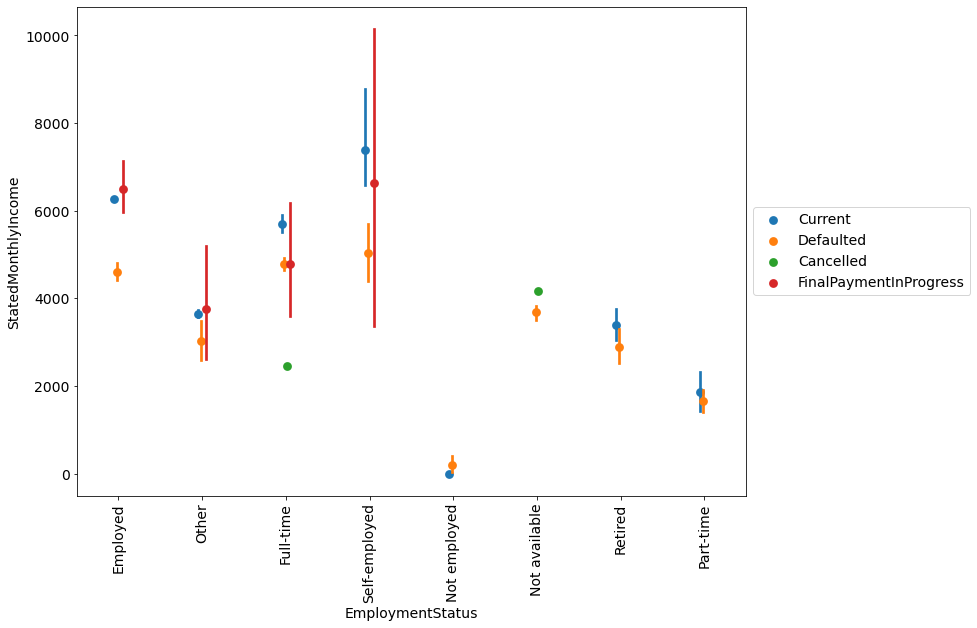

In [198]:
plt.figure(figsize=(12,9))
sb.pointplot(data = loan_data_sub, x = 'EmploymentStatus', \
             y = 'StatedMonthlyIncome', hue = 'loanstatus',
             linestyles = "",dodge=True)
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)) # legend to right of figure
plt.xticks(rotation = 90);


Looking at the income and their employment status of borrowers in the current, defaulted, cancelled and finalpayment process, it is evident that borrowers who are currently paying off debth and those making their final payments have higher incomce across several emplyment fields than those who have had their loans cancelled or defaulted.
Borrowers who are not employed have the lowest income with those  both defaulters and those currently paying loans having about the same income.



> - 3. Across all the employment status of borrowers, do those who default on loans have a higher dept to income ration than those currently paying their loans or those making their final payment?

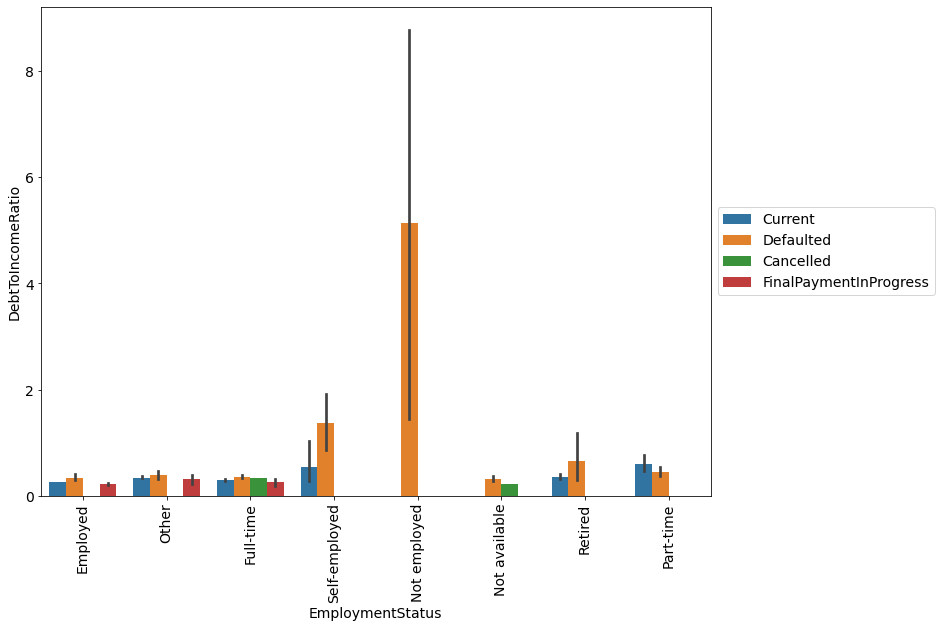

In [199]:
plt.figure(figsize=(12,9))
sb.barplot(data = loan_data_sub, x = 'EmploymentStatus', \
             y = 'DebtToIncomeRatio', hue = 'loanstatus')
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)) # legend to right of figure
plt.xticks(rotation = 90);

In addition, borrowers who are not employed thend to have the highest debt to income ratio and mostly defalut on loans.
This is followed by borrowers who are self emplyed, as they have the second highest debt to income ratio and the proportion of these borrowers whi default on their loans are more than those who currently pay their loans on schedule.

> - 4. Are there any noticeable correlation among the features studies so far?

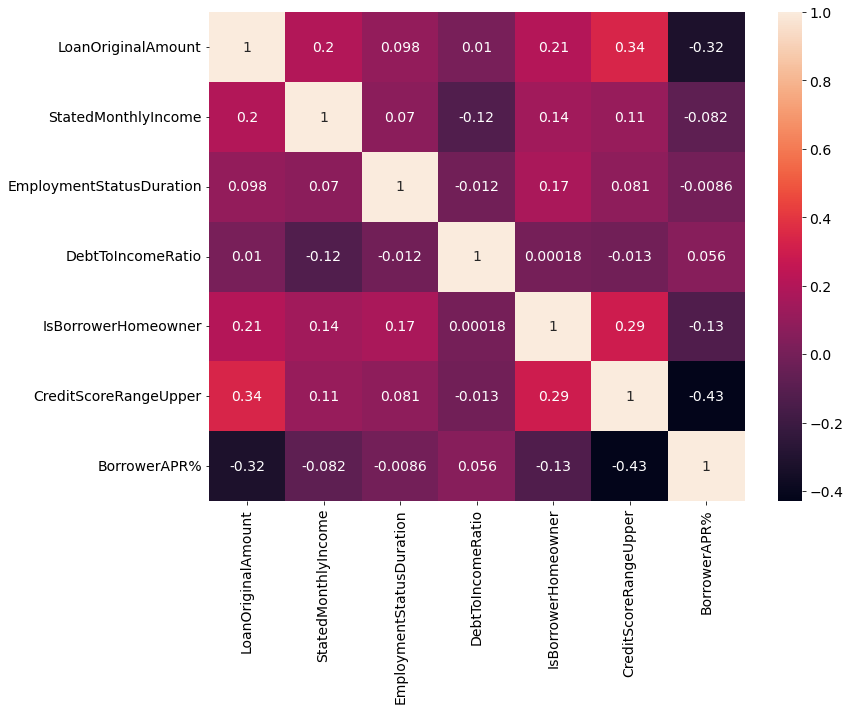

In [200]:
plt.figure(figsize=(12,9))
interest = ['LoanOriginalAmount','StatedMonthlyIncome'
            ,'EmploymentStatusDuration','DebtToIncomeRatio',
           'IsBorrowerHomeowner','CreditScoreRangeUpper',
           'BorrowerAPR%']

heatmap(interest)

There is a weak negative corelation between original loan amount and borrowerAPR%, thus these are inversely related.
There is also a weak positive correlation between loan original amount and credit score range upper.
There is a weak correlation between ishomeowner and loanoroginalamount.
There is a weak correlation between statedMonthlyincome and LoanOriginalAmount
there is also a weak correlation between ishomeowner and credit score.
there is also a weak correlation between ishomeowner and employmentstatusduration

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Looking at the income and their employment status of borrowers in the current, defaulted, cancelled and finalpayment process, it is evident that borrowers who are currently paying off debth and those making their final payments have higher incomce across several emplyment fields than those who have had their loans cancelled or defaulted. Borrowers who are not employed have the lowest income with those both defaulters and those currently paying loans having about the same income.

In addition, borrowers who are not employed thend to have the highest debt to income ratio and mostly defalut on loans.
This is followed by borrowers who are self emplyed, as they have the second highest debt to income ratio and the proportion of these borrowers whi default on their loans are more than those who currently pay their loans on schedule.

### Were there any interesting or surprising interactions between features?

Borrowers who default on their loans are generally have lower credit scores than those who currently pay their loans on schedule.
one would think that having a low credit score should rather motivate these borrowers to make due on their commitment on paying their loans.

## Conclusions
<a id="conclusions"></a>
The majority of borrowers have some form of employment, with 60.3% having employment and the most frequent salary range being $2,500 to $5,500. Most of these borrowers have a good standing with the bank, as they have a means of paying back the loan and a debt to loan ratio of only 0.2. The biggest borrowers are also the most compliant, with good standing borrowers having a lower borrower APR and higher income than those not in good standing with the bank. The inverse relationship between credit score range lower and borrower APR shows that borrowers with low credit scores have a higher borrower APR and are lent lesser money. Across all employment fields, non-employed, self-employed, and retired borrowers have a higher debt to income ratio and default the most on their loans. The data shows a weak negative correlation between original loan amount and borrower APR, and a weak positive correlation between loan original amount, credit score range upper, homeowner status, and stated monthly income.

#### Call to action 
Based on the insights and findings from the loan data analysis, it is clear that the employment status, credit score, income and homeowner status play a significant role in determining the loan amount, borrower APR, loan standing and likelihood of default. Given this information, it would be wise for lenders to consider these factors when evaluating loan applications. Additionally, borrowers can take steps to improve their credit score, increase their income and consider homeownership as a way to increase their chances of getting approved for a loan with better terms and conditions. By being proactive in improving these factors, both borrowers and lenders can benefit from better loan outcomes.